# CartPole REINFORCE from Scratch

Build the agent one component at a time. Run each cell in order and explore the outputs.

## 1. Imports and environment

Create the CartPole env. No policy yet — just confirm we can step with random actions and see rewards.

In [1]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [2]:
env = gym.make("CartPole-v1")
u = env.unwrapped
print(f"Angle limit: ±{getattr(u, 'theta_threshold_radians', None):.4f} rad = ±{np.degrees(getattr(u, 'theta_threshold_radians', 0)):.1f}°")
print(f"Cart position limit: ±{getattr(u, 'x_threshold', None)}")
env.close()

Angle limit: ±0.2094 rad = ±12.0°
Cart position limit: ±2.4


/home/srivatsas/work/repos/personal/Deep-Reinforcement-Learning-Hands-On-Third-Edition.git/main/.venv/lib/python3.11/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /home/srivatsas/work/repos/personal/Deep-Reinforcement-Learning-Hands-On-Third-Edition.git/main/learning/learning/videos_from_scratch folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/home/srivatsas/work/repos/personal/Deep-Reinforcement-Learning-Hands-On-Third-Edition.git/main/.venv/lib/python3.11/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


Observation shape: (4,) 
  Sample obs: [-0.04030071  0.0186624  -0.04266752 -0.03600497]
  Step 0: obs=-0.0399 angle=-0.0434 action=0, reward=1.0000, done=False
  Step 1: obs=-0.0434 angle=-0.0385 action=0, reward=1.0000, done=False
  Step 2: obs=-0.0508 angle=-0.0281 action=1, reward=1.0000, done=False
  Step 3: obs=-0.0543 angle=-0.0238 action=0, reward=1.0000, done=False
  Step 4: obs=-0.0617 angle=-0.0137 action=1, reward=1.0000, done=False
  Step 5: obs=-0.0652 angle=-0.0097 action=1, reward=1.0000, done=False
  Step 6: obs=-0.0648 angle=-0.0117 action=1, reward=1.0000, done=False
  Step 7: obs=-0.0604 angle=-0.0195 action=0, reward=1.0000, done=False
  Step 8: obs=-0.0600 angle=-0.0216 action=1, reward=1.0000, done=False
  Step 9: obs=-0.0557 angle=-0.0296 action=1, reward=1.0000, done=False
  Step 10: obs=-0.0474 angle=-0.0436 action=0, reward=1.0000, done=False
  Step 11: obs=-0.0431 angle=-0.0520 action=1, reward=1.0000, done=False
  Step 12: obs=-0.0348 angle=-0.0665 action=0

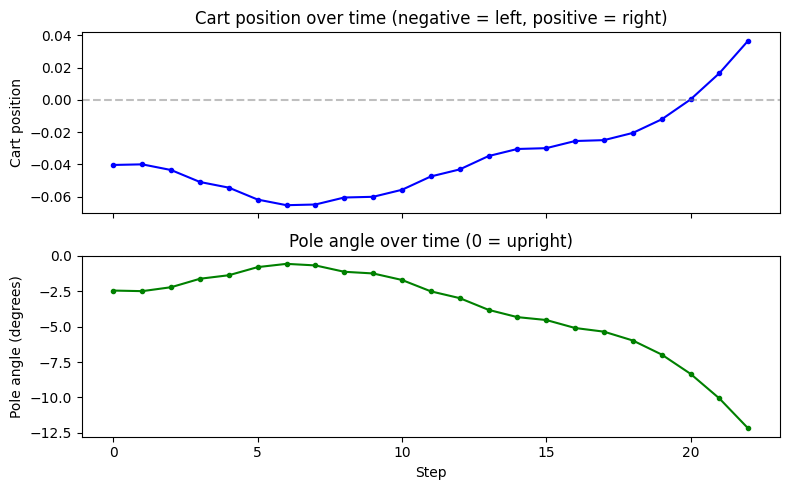

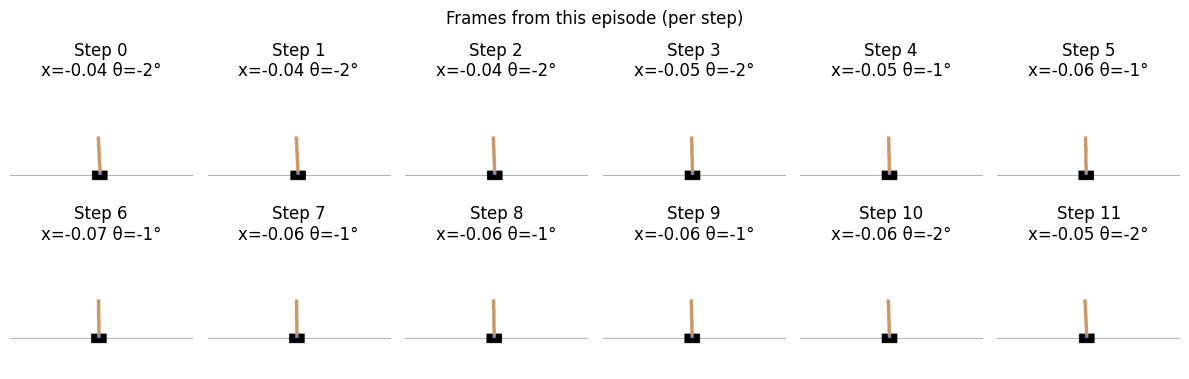

In [3]:
# Component 1: Imports and environment
# Create env with rendering, run one episode with random actions, record and show frames per step.
# Env with rgb_array so we can capture frames; RecordVideo saves the episode to a file
env = gym.make("CartPole-v1", render_mode="rgb_array")
env = RecordVideo(env, "learning/videos_from_scratch", episode_trigger=lambda e: True, disable_logger=True)

obs, info = env.reset()
print("Observation shape:", obs.shape, "\n  Sample obs:", obs)

# Run one full episode: collect frames and observations (to track cart position and pole angle)
# CartPole obs = (cart_x, cart_velocity, pole_angle_rad, pole_angular_velocity)
frames = []
observations = [obs.copy()]  # state at step 0 (before first action)
total_reward = 0.0
t = 0
while True:
    frame = env.render()
    if frame is not None:
        frames.append(frame)
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    observations.append(obs.copy())
    total_reward += reward
    done = terminated or truncated
    print(f"  Step {t}: obs={obs[0]:.4f} angle={obs[2]:.4f} action={action}, reward={reward:.4f}, done={done}")
    t += 1
    if done:
        break
env.close()
print("Total reward this episode:", total_reward)

# Trajectory: how cart position and pole angle changed over time
obs_arr = np.array(observations)
cart_pos = obs_arr[:, 0]       # cart position
pole_angle_deg = np.degrees(obs_arr[:, 2])  # pole angle in degrees

fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 5), sharex=True)
steps = np.arange(len(cart_pos))
ax1.plot(steps, cart_pos, "b-o", markersize=3)
ax1.set_ylabel("Cart position")
ax1.set_title("Cart position over time (negative = left, positive = right)")
ax1.axhline(0, color="gray", linestyle="--", alpha=0.5)
ax2.plot(steps, pole_angle_deg, "g-o", markersize=3)
ax2.set_ylabel("Pole angle (degrees)")
ax2.set_xlabel("Step")
ax2.set_title("Pole angle over time (0 = upright)")
ax2.axhline(0, color="gray", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# Grid of frames (first 12 steps)
n_show = min(12, len(frames))
fig2, axes = plt.subplots(2, 6, figsize=(12, 4))
axes = axes.flatten()
for i in range(n_show):
    axes[i].imshow(frames[i])
    x, th = cart_pos[i], pole_angle_deg[i]
    axes[i].set_title(f"Step {i}\nx={x:.2f} θ={th:.0f}°")
    axes[i].axis("off")
for j in range(n_show, len(axes)):
    axes[j].axis("off")
plt.suptitle("Frames from this episode (per step)")
plt.tight_layout()
plt.show()

## 2. Policy network

The policy maps an observation (4 numbers) to a probability over the two actions (left, right). We use a small neural net and softmax so the output sums to 1.

In [4]:
# Policy: observation (4) -> hidden -> 2 logits -> softmax -> P(left), P(right)
class Policy(nn.Module):
    def __init__(self, obs_size=4, hidden_size=128, n_actions=2):
        super().__init__()
        self.fc1 = nn.Linear(obs_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, n_actions)

    def forward(self, x):
        # x: (batch, 4)
        x = F.relu(self.fc1(x))
        logits = self.fc2(x)
        return F.softmax(logits, dim=1)

policy = Policy()
print(policy)

# Try it on one observation (no training yet)
env = gym.make("CartPole-v1")
obs, info = env.reset()
env.close()
x = torch.from_numpy(obs).float().unsqueeze(0)  # (1, 4)
with torch.no_grad():
    probs = policy(x)
print(f"Info - {info}")
print(f"probs - {probs}")
print("Observation (cart_x, cart_vel, pole_angle, pole_ang_vel):", obs)
print("Action probabilities [P(left), P(right)]:", probs[0].numpy())
print("Sum (should be 1):", probs[0].sum().item())

Policy(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)
Info - {}
probs - tensor([[0.5566, 0.4434]])
Observation (cart_x, cart_vel, pole_angle, pole_ang_vel): [ 0.02426631 -0.04775883  0.00505545  0.01311135]
Action probabilities [P(left), P(right)]: [0.55660254 0.44339746]
Sum (should be 1): 1.0


## 3. Select action

Given an observation, we run the policy to get action probabilities, then **sample** an action (left or right). We also store the **log-probability** of the chosen action — we need it later for the REINFORCE loss.

In [27]:
from torch.distributions import Categorical

def select_action(policy, observation):
    """Given obs (numpy array), return action (0 or 1) and its log-probability (tensor, for loss later)."""
    # Convert numpy obs to tensor, float32, and add batch dim (4,) -> (1, 4) for policy forward
    x = torch.from_numpy(observation).float().unsqueeze(0)
    # Policy forward: map state to P(left), P(right); probs shape (1, 2)
    probs = policy(x)
    # Categorical distribution over the two actions for sampling and log_prob
    dist = Categorical(probs)
    # Sample one action (0 or 1) according to probs
    action = dist.sample()
    # Log-probability of the chosen action (needed for REINFORCE loss gradient)
    log_prob = dist.log_prob(action)
    # action.item() = Python int for env.step(); log_prob kept as tensor for backward
    return action.item(), log_prob, probs

# Try it a few times (policy is still untrained)
env = gym.make("CartPole-v1")
obs, _ = env.reset()
for step in range(3000):
    action, log_prob, probs = select_action(policy, obs)
    print(f"Step {step}: obs[0]={obs[0]:.3f} obs[2]={obs[2]:.3f}  probs=[{probs[0,0].item():.3f}, {probs[0,1].item():.3f}]  action={action}  log_prob={log_prob.item():.4f}")
    obs, reward, terminated, truncated, _ = env.step(action)
    if terminated or truncated:
        #obs, _ = env.reset(seed=42)
        break
env.close()

Step 0: obs[0]=0.017 obs[2]=-0.009  probs=[0.553, 0.447]  action=0  log_prob=-0.5925
Step 1: obs[0]=0.017 obs[2]=-0.009  probs=[0.572, 0.428]  action=0  log_prob=-0.5581
Step 2: obs[0]=0.012 obs[2]=-0.004  probs=[0.583, 0.417]  action=0  log_prob=-0.5399
Step 3: obs[0]=0.003 obs[2]=0.008  probs=[0.585, 0.415]  action=0  log_prob=-0.5361
Step 4: obs[0]=-0.009 obs[2]=0.025  probs=[0.588, 0.412]  action=0  log_prob=-0.5307
Step 5: obs[0]=-0.025 obs[2]=0.049  probs=[0.588, 0.412]  action=0  log_prob=-0.5311
Step 6: obs[0]=-0.046 obs[2]=0.078  probs=[0.591, 0.409]  action=1  log_prob=-0.8928
Step 7: obs[0]=-0.070 obs[2]=0.113  probs=[0.591, 0.409]  action=1  log_prob=-0.8935
Step 8: obs[0]=-0.090 obs[2]=0.143  probs=[0.593, 0.407]  action=0  log_prob=-0.5228
Step 9: obs[0]=-0.107 obs[2]=0.168  probs=[0.595, 0.405]  action=0  log_prob=-0.5200
Step 10: obs[0]=-0.127 obs[2]=0.200  probs=[0.599, 0.401]  action=0  log_prob=-0.5126


## 4. Rollout (one episode)

Run one full episode: at each step call `select_action`, take the action in the env, and **store** the log-probability and reward. We do **not** do any backward or optimizer step here — we only collect data for the loss we'll compute at the end of the episode.

In [51]:
def rollout(env, policy):
    """Run one episode. Return log_probs, rewards, and probs (one per step) for logging certainty."""
    log_probs = []
    rewards = []
    probs = []
    obs, _ = env.reset()
    while True:
        action, log_prob, p = select_action(policy, obs)
        log_probs.append(log_prob)
        probs.append(p)
        obs, reward, terminated, truncated, _ = env.step(action)
        rewards.append(reward)
        if terminated or truncated:
            break
    return log_probs, rewards, probs

# Run one episode and inspect what we collected
env = gym.make("CartPole-v1")
log_probs, rewards, probs = rollout(env, policy)
env.close()
print(f"Episode length: {len(rewards)} steps")
print(f"Total reward: {sum(rewards)}")
print(f"log_probs: {len(log_probs)} tensors (one per step), dimensions: {log_probs[0].shape}")
print(f"rewards (first 5, ... last 3): {rewards[:5]} ... {rewards[-3:]}")

Episode length: 55 steps
Total reward: 55.0
log_probs: 55 tensors (one per step), dimensions: torch.Size([1])
rewards (first 5, ... last 3): [1.0, 1.0, 1.0, 1.0, 1.0] ... [1.0, 1.0, 1.0]


## 5. Compute returns from rewards

For each step *t*, the **return** G_t is the discounted sum of rewards from that step until the end of the episode:  
G_t = r_t + γ·r_{t+1} + γ²·r_{t+2} + ...  

We compute this from the list of rewards (no gradient). Optionally we normalize returns to reduce variance in the policy gradient.

In [52]:
def compute_returns(rewards, gamma=0.99, normalize=True):
    """
    rewards: list of rewards from the episode [r_0, r_1, ..., r_{T-1}]
    returns: list of G_t = r_t + gamma*r_{t+1} + gamma^2*r_{t+2} + ...
    """
    returns = []
    R = 0.0
    for r in reversed(rewards):
        R = r + gamma * R
        returns.append(R)
    returns = list(reversed(returns))
    returns = torch.tensor(returns, dtype=torch.float32)
    if normalize and len(returns) > 1:
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)
    return returns

# Use the last rollout's rewards (run the rollout cell first if needed)
# rewards = [1, 1, 1, ..., 1] for a 20-step episode
gamma = 0.99
returns = compute_returns(rewards, gamma=gamma)
print("Rewards (first 5, ... last 3):", rewards[:5], "...", rewards[-3:])
print("Returns G_t (first 5, ... last 3):", returns[:5].tolist(), "...", returns[-3:].tolist())
print("Returns shape:", returns.shape, "(same length as rewards)")

Rewards (first 5, ... last 3): [1.0, 1.0, 1.0, 1.0, 1.0] ... [1.0, 1.0, 1.0]
Returns G_t (first 5, ... last 3): [1.539628267288208, 1.4922871589660645, 1.4444677829742432, 1.3961652517318726, 1.3473751544952393] ... [-1.677545428276062, -1.7573833465576172, -1.8380277156829834]
Returns shape: torch.Size([55]) (same length as rewards)


## 6. Policy gradient loss and one update

REINFORCE loss: L = −Σ_t log π(a_t|s_t) · G_t. We minimize this (gradient descent) so that we **increase** the probability of actions that led to high return and **decrease** it for low return. This is the **only** place we call `.backward()` and `optimizer.step()` — once per episode.

In [53]:
optimizer = torch.optim.Adam(policy.parameters(), lr=1e-2)

def policy_gradient_update(policy, optimizer, log_probs, returns):
    """One REINFORCE update: loss = -sum(log_prob_t * G_t), then backward + step."""
    # returns is a tensor; log_probs is a list of tensors from the episode
    loss = -sum(log_p * R for log_p, R in zip(log_probs, returns))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

# Use the last rollout's log_probs and the returns we computed (run rollout + compute_returns cells first)
loss_val = policy_gradient_update(policy, optimizer, log_probs, returns)
print(f"One update done. Loss (before negated sum): {loss_val:.4f}")

One update done. Loss (before negated sum): -6.9081


## 7. Full training loop

For each episode: **rollout** → **compute returns** → **policy gradient update**. Track episode rewards and optionally stop when the policy is good enough (e.g. average reward over recent episodes exceeds the env's reward threshold).

## 8. TensorBoard setup

Create a SummaryWriter so the training loop can log episode reward, running reward, and loss. Run `tensorboard --logdir runs` to view the curves.

In [55]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("runs/cartpole_from_scratch")

In [56]:
gamma = 0.99
max_episodes = 500
print_every = 50

env = gym.make("CartPole-v1")
reward_threshold = getattr(env.spec, "reward_threshold", 195)  # CartPole-v1: "solved" at 195
running_reward = 10.0

for episode in range(max_episodes):
    log_probs, rewards, probs = rollout(env, policy)
    returns = compute_returns(rewards, gamma=gamma)
    loss_val = policy_gradient_update(policy, optimizer, log_probs, returns)

    ep_reward = sum(rewards)
    running_reward = 0.05 * ep_reward + 0.95 * running_reward

    # Policy certainty: lower entropy = more confident; higher max_prob = more confident
    probs_stacked = torch.cat(probs, dim=0)
    entropy = -(probs_stacked * (probs_stacked.clamp(min=1e-8).log())).sum(dim=1).mean().item()
    mean_max_prob = probs_stacked.max(dim=1)[0].mean().item()

    writer.add_scalar("train/episode_reward", ep_reward, episode)
    writer.add_scalar("train/running_reward", running_reward, episode)
    writer.add_scalar("train/loss", loss_val, episode)
    writer.add_scalar("train/policy_entropy", entropy, episode)
    writer.add_scalar("train/mean_max_prob", mean_max_prob, episode)

    if (episode + 1) % print_every == 0:
        print(f"Episode {episode + 1}: reward={ep_reward:.0f}, running_reward={running_reward:.1f}")

    if running_reward >= reward_threshold:
        print(f"Solved at episode {episode + 1}. Running reward {running_reward:.1f} >= {reward_threshold}")
        break

env.close()
writer.close()

Episode 50: reward=81, running_reward=77.5
Episode 100: reward=85, running_reward=92.1
Episode 150: reward=144, running_reward=96.3
Episode 200: reward=58, running_reward=76.7
Episode 250: reward=68, running_reward=94.7
Episode 300: reward=90, running_reward=110.9
Episode 350: reward=68, running_reward=61.4
Episode 400: reward=78, running_reward=57.0
Episode 450: reward=34, running_reward=36.9
Episode 500: reward=63, running_reward=35.7


## 9. Video with trained policy

Run one episode with the trained policy and record it. Video is saved under `learning/videos_from_scratch/` (or the path you pass to RecordVideo). Run the training loop first so `policy` is trained.

In [ ]:
from gymnasium.wrappers import RecordVideo

# Record one episode with the trained policy
env = gym.make("CartPole-v1", render_mode="rgb_array")
env = RecordVideo(env, "learning/videos_from_scratch", episode_trigger=lambda e: True, disable_logger=True)
log_probs, rewards, _ = rollout(env, policy)
env.close()
print(f"Recorded episode: {len(rewards)} steps, total reward {sum(rewards):.0f}")
print("Video saved in learning/videos_from_scratch/")